In [ ]:
# imports
import re, nltk, gensim, pyLDAvis, nlp
nltk.download("stopwords")
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter()

from tqdm import tqdm

In [2]:
# splitting dataset
def split():
    df = pd.read_csv("all.csv")

    df["text"] = df["text"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df["text"] = df["text"].str.replace("[\\n]", "", regex=True)
    df["text"] = df["text"].str.replace("[\\r]", "", regex=True)

    df_male = df[df["text"].str.contains('[0-9][0-9](m|(( y\/o| year old)) (dude|boy|guy|man|male))', regex=True)]
    df_male.to_excel("male.xlsx")
    df_female = df[df["text"].str.contains('[0-9][0-9](f|(( y\/o| year old)) (woman|lady|girl|female))', regex=True)]
    df_female.to_excel("female.xlsx")

    print(len(df_male))
    print(len(df_female))
    print(df_male.head())
    print(df_female.head())

    return df_male, df_female

In [3]:
# loading data
# df_male, df_female = split()
df_male = pd.read_excel("results/male.xlsx").dropna()
df_female = pd.read_excel("results/female.xlsx").dropna()

data_male = df_male.text.tolist()
data_female = df_female.text.tolist()

In [4]:
# cleaning data a bit

# remove emails
data_male = [re.sub(r"\S*@\S*s?", "", i) for i in data_male]

# remove new lines
data_male = [re.sub(r"\s+", " ", i) for i in data_male]

# remove emails
data_female = [re.sub(r"\S*@\S*s?", "", i) for i in data_female]

# remove new lines
data_female = [re.sub(r"\s+", " ", i) for i in data_female]

In [5]:
# tokenizer
def tokenize(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_male_words = list(tokenize(data_male))
data_female_words = list(tokenize(data_female))

In [6]:
# remove stopwords + lemmatize
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

lemmatizer = WordNetLemmatizer()

def remove_stopwords(texts):
    cleaned_texts = []
    for text in texts:
        cleaned = [w for w in text if not w.lower() in stopwords]
        cleaned = [lemmatizer.lemmatize(w) for w in cleaned]
        cleaned_texts.append(cleaned)
    return cleaned_texts

data_male_stopped = remove_stopwords(data_male_words)
data_female_stopped = remove_stopwords(data_female_words)

In [7]:
# create ID dictionary & corpus
id2word_male = corpora.Dictionary(data_male_stopped)
id2word_female = corpora.Dictionary(data_female_stopped)

corpus_male = [id2word_male.doc2bow(text) for text in data_male_stopped]
corpus_female = [id2word_female.doc2bow(text) for text in data_female_stopped]

In [ ]:
def compute_coherence(dictionary, corpus, texts, limit, start=5, step=5, a=None, b=None):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, random_state=100,
                                               passes=50, iterations=500, per_word_topics=True, id2word=dictionary, alpha=a, eta=b)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

In [ ]:
model_list_male, coherence_values_male = compute_coherence(dictionary=id2word_male, corpus=corpus_male, texts=data_male_stopped, start=5, limit=45, step=5, a=0.61, b=0.9099999999999999)
model_list_female, coherence_values_female = compute_coherence(dictionary=id2word_female, corpus=corpus_female, texts=data_female_stopped, start=5, limit=45, step=5, a="asymmetric", b=0.9099999999999999)

In [ ]:
start = 5
limit = 45
step = 5
x_key = range(start, limit, step)

plt.plot(x_key, coherence_values_male)
plt.title("Coherence Score vs # of Topics (Male)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_male"), loc="best")
plt.show()

plt.plot(x_key, coherence_values_female)
plt.title("Coherence Score vs # of Topics (Female)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_male"), loc="best")
plt.show()

for m, cv in zip(x_key, coherence_values_male):
    print("male: topics=", m, ": coherence=", round(cv, 5))
    
for m, cv in zip(x_key, coherence_values_female):
    print("female: topics=", m, ": coherence=", round(cv, 5))

In [ ]:
pp.pprint(model_list_male[4].print_topics())
print("===female===")
pp.pprint(model_list_female[5].print_topics())

In [ ]:
# setup for optimization
min_topics = 10
max_topics = 50
step_size = 5
topics_range = range(min_topics, max_topics, step_size)

# alpha
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append("symmetric")
alpha.append("asymmetric")

# beta
beta = list(np.arange(0.01, 1, 0.3))
beta.append("symmetric")

In [ ]:
def compute_cv_once(corpus, dictionary, texts, k, a, b):
    model = gensim.models.LdaMulticore(corpus=corpus, num_topics=k, random_state=100,
                                               passes=50, iterations=500, per_word_topics=True, id2word=dictionary, alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
    return coherence_model_lda.get_coherence()

In [ ]:
# male optimization

male_results = {"Topics": [],
               "Alpha": [],
               "Beta": [],
               "Coherence": []}

num_docs_male = len(corpus_male)

#for i in tqdm(range(len(corpus_male))):
for k in tqdm(topics_range):
    print("topics: ", k)
    for a in tqdm(alpha):
        print("alpha: ", a)
        for b in tqdm(beta):
            print("beta: ", b)
            cv = compute_cv_once(dictionary=id2word_male, corpus=corpus_male, texts=data_male_stopped, k=k, a=a, b=b)
            print(cv)
            male_results["Topics"].append(k)
            male_results["Alpha"].append(a)
            male_results["Beta"].append(b)
            male_results["Coherence"].append(cv)
pd.DataFrame(male_results).to_csv("lda_tuning_male.csv", index=False)


In [ ]:
# female optimization

female_results = {"Topics": [],
               "Alpha": [],
               "Beta": [],
               "Coherence": []}

num_docs_female = len(corpus_female)

#for i in tqdm(range(len(corpus_female))):
for k in tqdm(topics_range):
    print("topics: ", k)
    for a in tqdm(alpha):
        print("alpha: ", a)
        for b in tqdm(beta):
            print("beta: ", b)
            cv = compute_cv_once(dictionary=id2word_female, corpus=corpus_female, texts=data_female_stopped, k=k, a=a, b=b)
            print(cv)
            male_results["Topics"].append(k)
            male_results["Alpha"].append(a)
            male_results["Beta"].append(b)
            male_results["Coherence"].append(cv)
pd.DataFrame(male_results).to_csv("lda_tuning_female.csv", index=False)


In [ ]:
# final LDAs
lda_male = gensim.models.ldamodel.LdaModel(corpus=corpus_male,
                                          id2word=id2word_male,
                                          num_topics=10,
                                          random_state=100,
                                          passes=50,
                                          iterations=500,
                                          per_word_topics=True,
                                          alpha=0.01,
                                          eta=0.91)

lda_female = gensim.models.LdaMulticore(corpus=corpus_female,
                                            id2word=id2word_female,
                                            num_topics=10,
                                            random_state=100,
                                            passes=50,
                                            iterations=500,
                                            eval_every=1,
                                            per_word_topics=True,
                                            alpha=0.01,
                                            eta=0.91)

In [ ]:
print("===male===")
pp.pprint(lda_male.print_topics())
print("===female===")
pp.pprint(lda_female.print_topics())

In [8]:
# ===begin new approach (Gibbs Sampling LDA instead of Variational Bayes===
# setup for MALLET (Gibbs Sampling LDA)
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:\mallet-2.0.8'}) 
mallet_path = r'C:/mallet-2.0.8/bin/mallet.bat' 

In [41]:
def calculate_coherence_gibbs(corpus, texts, num_topics, id2word):
    model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=num_topics,
                                            iterations=1000, id2word=id2word, optimize_interval=1)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
    return model, coherence_model.get_coherence()

In [43]:
# doing MALLET and optimization for male ---> best: k=60

# test 10-70 topics
coherence_values_male = []
model_list_male = []
for num_topics in tqdm(range(10, 75, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_male, data_male_stopped, num_topics, id2word_male)
    model_list_male.append(model)
    coherence_values_male.append(coherence_value)

100%|██████████| 13/13 [11:58<00:00, 55.30s/it]


In [88]:
# doing MALLET and optimization for female ---> best: k=60

# test 10-70 topics
coherence_values_female = []
model_list_female = []
for num_topics in tqdm(range(10, 75, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_female, data_female_stopped, num_topics, id2word_female)
    model_list_female.append(model)
    coherence_values_female.append(coherence_value)

100%|██████████| 13/13 [12:04<00:00, 55.75s/it]


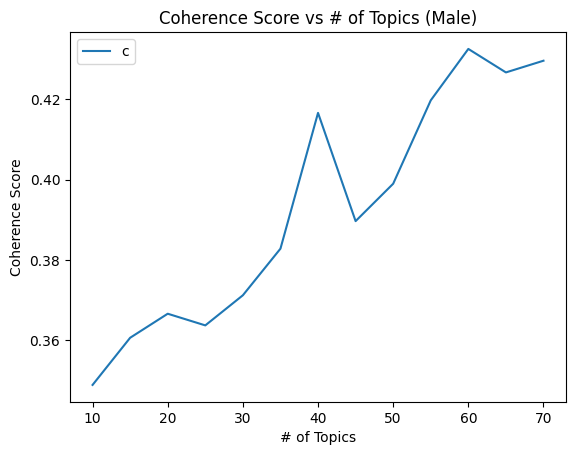

In [44]:
# display MALLET optimization for K for males
start = 10
limit = 75
step = 5
x_key = range(start, limit, step)

plt.plot(x_key, coherence_values_male)
plt.title("Coherence Score vs # of Topics (Male)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_male"), loc="best")
plt.show()

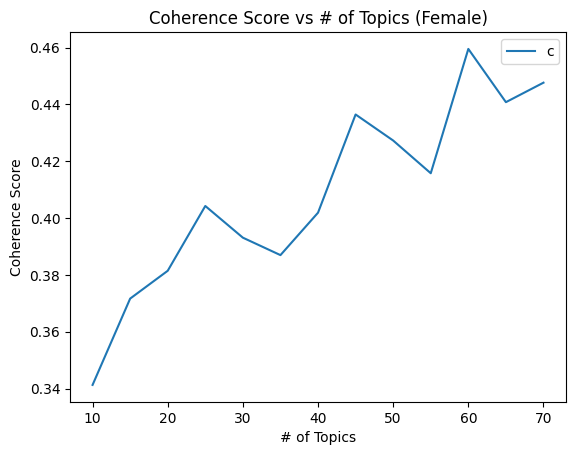

In [89]:
# display MALLET optimization for K for females
start = 10
limit = 75
step = 5
x_key = range(start, limit, step)

plt.plot(x_key, coherence_values_female)
plt.title("Coherence Score vs # of Topics (Female)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_female"), loc="best")
plt.show()

In [66]:
# best k for male: k=60; k~20
pp.pprint(model_list_male[10].print_topics())

[(35,
  'nan*"syncope" + nan*"ringing" + nan*"checking" + nan*"checked" + '
  'nan*"beating" + nan*"awareness" + nan*"contribute" + nan*"symptom" + '
  'nan*"monitoring" + nan*"pressure"'),
 (59,
  'nan*"syncope" + nan*"ringing" + nan*"checking" + nan*"checked" + '
  'nan*"beating" + nan*"awareness" + nan*"contribute" + nan*"symptom" + '
  'nan*"monitoring" + nan*"pressure"'),
 (52,
  '0.115*"fatigue" + 0.077*"honestly" + 0.077*"neuropathy" + 0.038*"office" + '
  '0.038*"prize" + 0.038*"banking" + 0.038*"coping" + 0.038*"highkey" + '
  '0.038*"mri" + 0.038*"mystery"'),
 (0,
  '0.071*"monster" + 0.036*"added" + 0.036*"relentless" + 0.036*"title" + '
  '0.036*"slayed" + 0.036*"afraid" + 0.036*"offical" + 0.036*"affection" + '
  '0.036*"deserved" + 0.036*"avoided"'),
 (41,
  '0.038*"insane" + 0.038*"divorced" + 0.038*"drug" + 0.038*"meaning" + '
  '0.019*"outsider" + 0.019*"finance" + 0.019*"commit" + 0.019*"crackheads" + '
  '0.019*"bribed" + 0.019*"countertop"'),
 (49,
  '0.081*"hated" 

In [90]:
# best k for female: k=60; k~20
pp.pprint(model_list_female[10].print_topics())

[(17,
  '0.063*"long" + 0.048*"body" + 0.032*"chest" + 0.032*"heaven" + 0.024*"eat" '
  '+ 0.024*"imagine" + 0.024*"purpose" + 0.016*"wake" + 0.016*"interest" + '
  '0.016*"art"'),
 (38,
  '0.044*"couple" + 0.044*"country" + 0.022*"enjoys" + 0.022*"mini" + '
  '0.022*"stroke" + 0.022*"dr" + 0.022*"titanium" + 0.022*"job" + '
  '0.022*"movie" + 0.022*"watching"'),
 (33,
  '0.122*"semester" + 0.049*"christmas" + 0.049*"ended" + 0.049*"reality" + '
  '0.024*"paper" + 0.024*"sad" + 0.024*"loneliness" + 0.024*"microbiology" + '
  '0.024*"opportunity" + 0.024*"theyd"'),
 (52,
  '0.094*"deviation" + 0.075*"scare" + 0.038*"threat" + 0.038*"stopped" + '
  '0.038*"face" + 0.038*"insult" + 0.038*"leave" + 0.038*"wear" + '
  '0.038*"notice" + 0.038*"reassurance"'),
 (49,
  '0.092*"beat" + 0.053*"dad" + 0.039*"lb" + 0.039*"met" + 0.026*"told" + '
  '0.026*"tolerate" + 0.026*"silent" + 0.026*"mother" + 0.026*"complain" + '
  '0.026*"fucking"'),
 (42,
  '0.118*"move" + 0.066*"mother" + 0.039*"teen" +

In [94]:
# get distribution of topics for male

from operator import itemgetter

most_probable_topics_male = []

for topics in model_list_male[10][corpus_male]:
    # get first most prob
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])
    # get second most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])
    # get third most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])

NameError: name 'model_list_male' is not defined

In [102]:
# get distribution of topics for female

from operator import itemgetter

most_probable_topics_female = []

for topics in model_list_female[10][corpus_female]:
    # get first most prob
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])
    # get second most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])
    # get third most prob
    topics.remove(max(topics, key=itemgetter(1)))
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])


In [93]:
# display the distribution of topics for male

plt.hist(most_probable_topics_male, edgecolor="black", bins=60)
plt.xticks(range(0, 60, 6))
plt.title("Distribution of Topics (Male)")

NameError: name 'most_probable_topics_male' is not defined

Text(0.5, 1.0, 'Distribution of Topics (Female)')

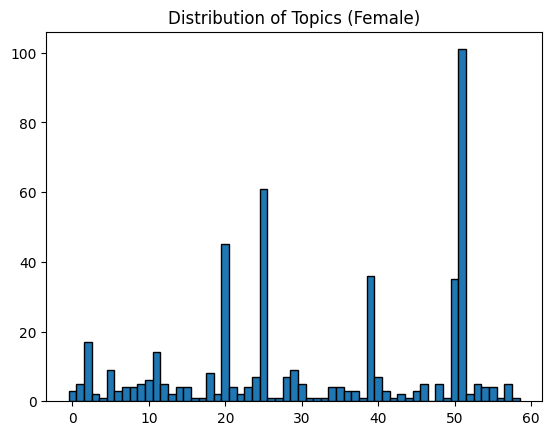

In [137]:
# display the distribution of topics for female
plt.hist(most_probable_topics_female, edgecolor="black", bins=np.arange(60)-0.5)
#plt.xticks(np.unique(np.array(most_probable_topics_female)))
#plt.xticks(range(0, 60, 1))
plt.title("Distribution of Topics (Female)")